In [ ]:
#Masterprojekt SFH - 1 Verbraucher, 1 Wärmepumpe, 1 Speicher

import logging
logger = logging.getLogger("gurobipy")
logger.propagate = False

import pandas as pd
import pypsaheat as ph
import pypsa

: 

In [36]:
#Einlesen der Lastgänge

#df_data = pd.read_csv('when2heat_filtered_2019-12-29-2019-12-31.csv', index_col='utc_timestamp')
#df_data_weather = pd.read_csv('weather_data_filtered_2019-12-29-2019-12-31.csv', index_col='utc_timestamp')
df_data = pd.read_excel('Uebung_01_data.xlsx', index_col='time')

In [37]:
df_data

,electricity,PV,temp,heat_water,heat_space
time,,,,,
2020-03-30 00:00:00,0.342904,0.000,-2.620,0.028805,2.271993
2020-03-30 01:00:00,0.102076,0.000,-3.313,0.036006,2.335993
2020-03-30 02:00:00,0.185367,0.000,-3.869,0.028805,2.415993
2020-03-30 03:00:00,0.198504,0.000,-4.301,0.052809,2.575992
2020-03-30 04:00:00,0.297293,0.000,-4.747,0.127221,2.975991
...,...,...,...,...,...
2020-04-05 19:00:00,0.839571,0.039,13.508,0.338456,2.751992
2020-04-05 20:00:00,0.676292,0.000,11.191,0.350458,2.607992
2020-04-05 21:00:00,0.509222,0.000,10.786,0.300050,2.287993


In [13]:
#df_data_weather

<Axes: xlabel='time'>

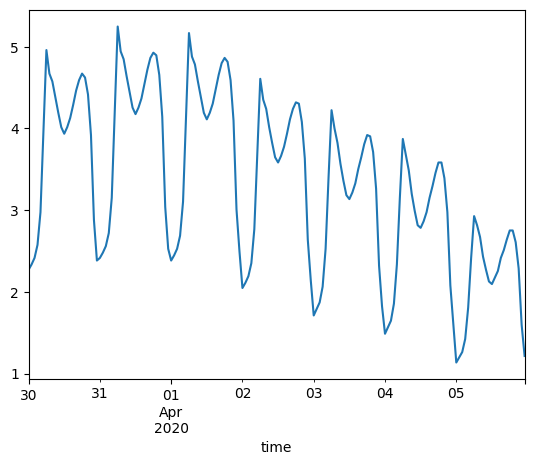

In [14]:
#Zuordnung der Daten aus den Lastgängen
raumwaerme = df_data['heat_space'] #Heizlast von SFH in kW
raumwaerme.plot()

In [15]:
# warmwasser = df_data['DE_heat_profile_water_SFH']/1000 #Warmwasserlast von SFH in kW
# warmwasser.plot()


<Axes: xlabel='time'>

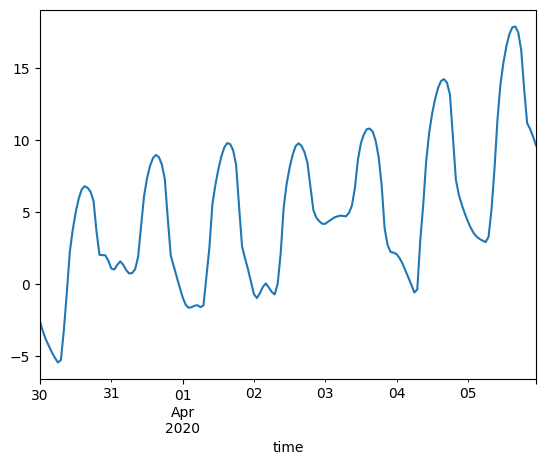

In [16]:
# aussentemperatur = df_data_weather['DE_temperature']
aussentemperatur = df_data['temp']
aussentemperatur.plot()

In [ ]:
# cop_hp = df_data ['DE_COP_ASHP_radiator']
cop_hp = 3.5 #Konstant oder doch lieber variable?
# cop_hp.plot()

<Axes: xlabel='time'>

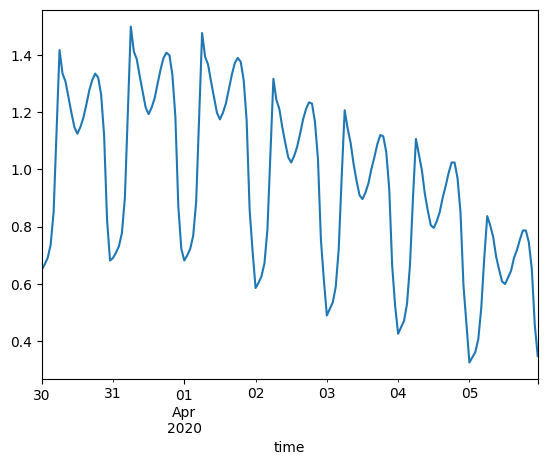

In [ ]:
# power_demand_hp = (raumwaerme + warmwasser) / cop_hp 
power_demand_hp = (raumwaerme) / cop_hp
power_demand_hp.plot()

In [19]:
#Strom
grid_cost = 0.35 # €/kWh Kosten für Netzstrombezug
grid_power = 20 #kW Hausanschluss Leistung

In [20]:
#Wärmespeicher eigenschaften 
#wie konstanter Volumenspeicher)
Store_height = 2 #m
Store_base = 0.8 #m²
Store_layer = 3
#Store_T_layers = [55, 50] #°C Temperaturschichten
#Store_T_return = 45 #°C Rücklauftemperatur

T_Warmwasser = 55

In [ ]:
#Wärmepumpen eigenschaften
HP_power = 8 #kW Wärmepumpenleistung

<Axes: xlabel='time'>

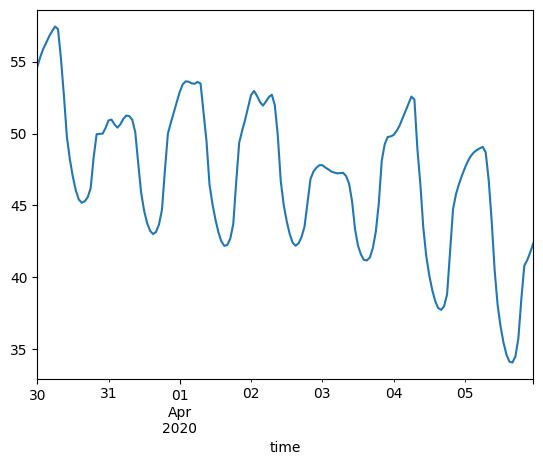

In [22]:
# Vorlauftemperatur für Heizsystem
T_at_0 = 52  #°C Vorlauftemperatur bei Außentemperatur 0°C
T_gradient = 1  #°C/°C Steigung der Heizkurve

T_flow = ph.physics.flow_temperature(T_at_0, T_gradient, aussentemperatur)
T_flow.plot()

In [ ]:
# Aufbau des Modells
n = ph.HeatNetwork()

n.set_snapshots(df_data.index)

n.add("Bus",  
      name = "electricity"      
)

n.add('Generator',
      bus = 'electricity',
      name = 'grid',
      p_nom = grid_power,
      marginal_cost = grid_cost
  )

n.add('Load', 
      bus = 'electricity', 
      name = 'Elektrische Last',
      p_set = power_demand_hp
)

#Hinzufügen eines Schichtspeichers mit konstanten Volumschichten
n.add('HeatStore',
      name = 'hs',
      constant = 'volume',
      height = Store_height, # Höhe in m
      base = Store_base, # Grundfläche in m² 
      #T_return = Store_T_return,
      #T_max = 65, #maximale Speichertemperatur
      n_layer = 3,
      cyclic = True #cyclic was war das nochmal?
      )

#Hinzufügen einer Wärmepumpe an den Wärmespeicher
n.add('HeatPump',
      name = 'hp',
      bus0 = 'electricity',
      m_nom = 700, # kg/h warum ist das so?
      heat_store = 'hs',
      T_source = df_data['temp'],
      T_nom = 65,
      heat_source  = 'air'
      )

#Hinzufügen der Raumwärmelast
n.add('HeatLoad',
      name = 'heat_space_demand',
      heat_store = 'hs',
      p_set = df_data['heat_space'],
      T_demand = T_flow
      )

#Hinzufügen der Warmwasserlast
# n.add('HeatLoad',
#       name = 'heat_water_demand',
#       heat_store = 'hs',
#       p_set = df_data['DE_heat_profile_water_SFH']/1000,
#       T_demand = T_Warmwasser
#       )



c:\Users\Robin Remmers\Desktop\projekte\.venv\Lib\site-packages\pypsa\components.py:836: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([cls_df, obj_df], sort=False)
c:\Users\Robin Remmers\Desktop\projekte\.venv\Lib\site-packages\pypsa\components.py:836: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([cls_df, obj_df], sort=False)
c:\Users\Robin Remmers\Desktop\projekte\.venv\Lib\site-packages\pypsa\components.py:836: FutureWarning: The behavior of DataFrame co

In [24]:
n.heat_loads

attribute,heat_store,carrier,type,p_set,T_demand,T_diff_return,internal_exchange,outlet_height,inlet_height
HeatLoad,,,,,,,,,
heat_space_demand,hs,,,0.0,50.0,10.0,False,1.0,0.0


In [26]:
n.optimize(solver_name = 'gurobi')
n.optimize.optimize_with_rolling_horizon(horizon = 24, overlap = 2)

Index(['electricity'], dtype='object', name='Bus')


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.13s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-ooy4m9mv.lp
Reading time = 0.06 seconds
obj: 4200 rows, 1512 columns, 10080 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4200 rows, 1512 columns and 10080 nonzeros
Model fingerprint: 0x5941fdf0
Variable types: 1344 continuous, 168 integer (168 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 1512 rows and 168 columns
Presolve time: 0.03s
Presolved: 2688 rows, 1344 columns, 8400 nonzeros
Variable types: 1176 continuous, 168 integer (168 binary)

Root relaxation: objective 1.494455e+02, 4740 iterations, 0.38 seconds (0.33 work units)

    No

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1512 primals, 0 duals
Objective: 1.58e+02
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-03-30 00:00:00:2020-03-30 23:00:00] (1/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-1w3zpvh3.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0x9a68e07c
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 2.624367e+01, 555 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 2.76e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-03-30 22:00:00:2020-03-31 21:00:00] (2/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-_3df0kn8.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0x1da2c746
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 2.693509e+01, 539 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 2.80e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-03-31 20:00:00:2020-04-01 19:00:00] (3/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-6wvwyx05.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0x1a378ad1
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 2.617239e+01, 704 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 2.77e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-04-01 18:00:00:2020-04-02 17:00:00] (4/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-3rji0sjf.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0xb85c1283
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 2.358278e+01, 479 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 2.49e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-04-02 16:00:00:2020-04-03 15:00:00] (5/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-9d0dllz9.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0x2df46dcf
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 2.091869e+01, 563 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 2.16e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-04-03 14:00:00:2020-04-04 13:00:00] (6/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-ybo514r5.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0xe9c54e05
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 1.840864e+01, 549 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 1.94e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-04-04 12:00:00:2020-04-05 11:00:00] (7/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-dnqq2jk3.lp
Reading time = 0.02 seconds
obj: 600 rows, 216 columns, 1440 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 600 rows, 216 columns and 1440 nonzeros
Model fingerprint: 0xfd306239
Variable types: 192 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 216 rows and 24 columns
Presolve time: 0.01s
Presolved: 384 rows, 192 columns, 1200 nonzeros
Variable types: 168 continuous, 24 integer (24 binary)

Root relaxation: objective 1.502004e+01, 766 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Curre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 216 primals, 0 duals
Objective: 1.55e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsaheat.optimization.optimize:Optimizing network for snapshot horizon [2020-04-05 10:00:00:2020-04-05 23:00:00] (8/8).
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Set parameter LicenseID to value 2728110
Academic license - for non-commercial use only - expires 2026-10-27


INFO:linopy.io: Writing time: 0.06s


Read LP format model from file C:\Users\Robin Remmers\AppData\Local\Temp\linopy-problem-5f5508xm.lp
Reading time = 0.02 seconds
obj: 350 rows, 126 columns, 840 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350 rows, 126 columns and 840 nonzeros
Model fingerprint: 0x4c6b58dc
Variable types: 112 continuous, 14 integer (14 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 126 rows and 14 columns
Presolve time: 0.01s
Presolved: 224 rows, 112 columns, 700 nonzeros
Variable types: 98 continuous, 14 integer (14 binary)

Root relaxation: objective 7.530390e+00, 367 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current N

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 126 primals, 0 duals
Objective: 7.67e+00
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.


<Axes: title={'center': 'Temperaturverlauf der Speicherschichten'}, xlabel='snapshot'>

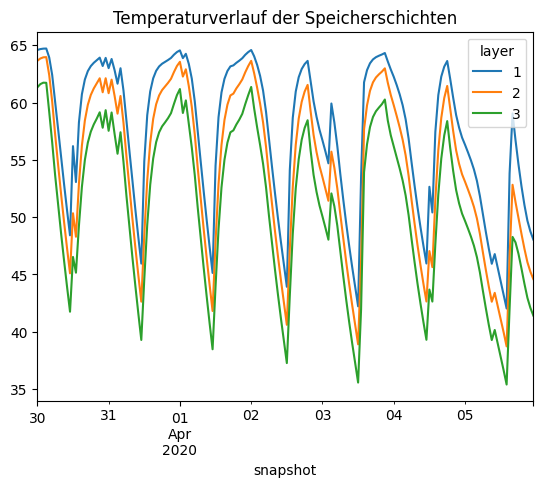

In [29]:
n.heat_stores_t
df = n.heat_stores_t['hs-T_layer']

df.plot(title='Temperaturverlauf der Speicherschichten')
